# HSE 2023: Введение в машинное обучение БИ 23/24

## ДЗ 2

# Внимание!
Если в задании просят объяснить что-либо, то это значит, что требуется письменный ответ, который является частью задания и оценивается

Мы только принимаем ipynb ноутбуки. Если вы используете Google Colab, то вам необходимо скачать ноутбук перед сдачей ДЗ


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import datasets
# from sklearn.datasets import load_boston
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLSResults
from math import sqrt
import random
import sys

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

sns.set(style="darkgrid")

### Данные

Для этого ДЗ мы будем использовать датасет треков со стримингового сервиса Spotify

**Описание данных**

- **track_id:** The Spotify ID for the track
- **artists:** The artists' names who performed the track. If there is more than one artist, they are separated by a ;
- **album_name:** The album name in which the track appears
- **track_name:** Name of the track
- **popularity:** The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are. Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past. Duplicate tracks (e.g. the same track from a single and an album) are rated independently. Artist and album popularity is derived mathematically from track popularity.
- **duration_ms:** The track length in milliseconds
- **explicit:** Whether or not the track has explicit lyrics (true = yes it does; false = no it does not OR unknown)
- **danceability:** Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable
- **key:** The key the track is in. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1
- **loudness:** The overall loudness of a track in decibels (dB)
- **mode:** Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0
- **speechiness:** Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks
- **acousticness:** A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic
- **instrumentalness:** Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content
- **liveness:** Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live
- **valence:** A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry)
- **tempo:** The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration
- **time_signature:** An estimated time signature. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of 3/4, to 7/4.
- **track_genre:** The genre in which the track belongs

**Целевая переменная**
- **energy:** Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale

In [2]:
data = pd.read_csv('dataset.csv')

y = data['energy']
X = data.drop(['energy'], axis=1)
columns = X.columns

data.tail()

,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
113995,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Sleep My Little Boy,21,384999,False,0.172,0.235,5,-16.393,1,0.0422,0.640,0.928,0.0863,0.0339,125.995,5,world-music
113996,Rainy Lullaby,#mindfulness - Soft Rain for Mindful Meditatio...,Water Into Light,22,385000,False,0.174,0.117,0,-18.318,0,0.0401,0.994,0.976,0.1050,0.0350,85.239,4,world-music
113997,Cesária Evora,Best Of,Miss Perfumado,22,271466,False,0.629,0.329,0,-10.895,0,0.0420,0.867,0.000,0.0839,0.7430,132.378,4,world-music
113998,Michael W. Smith,Change Your World,Friends,41,283893,False,0.587,0.506,7,-10.889,1,0.0297,0.381,0.000,0.2700,0.4130,135.960,4,world-music
113999,Cesária Evora,Miss Perfumado,Barbincor,22,241826,False,0.526,0.487,1,-10.204,0,0.0725,0.681,0.000,0.0893,0.7080,79.198,4,world-music


## Линейная регрессия

#### 0. [0.25 балла] Закодируйте категориальные признаки. Объясните выбранный вами метод.

In [347]:
# Посмотрим на сводку категориальных признаков
data.select_dtypes(include=['object']).describe()

,artists,album_name,track_name,track_genre
count,113999,113999,113999,114000
unique,31437,46589,73608,114
top,The Beatles,Alternative Christmas 2022,Run Rudolph Run,acoustic
freq,279,195,151,1000


##### Как мы можем видеть, у признаков artists, album_name и track_name очень много уникальных значений, поэтому можно сделать предположение о том, что они никак не повлияют на результат прогноза модели и мы можем их исключить

##### Метод Label encoding нам не подойдет, потому что значения признака track_genre(у нас остался 1 категориальный столбец) никак не упорядочены и ранжированы, поэтому, чтобы модель не подумала, что значения имеют какую-то связь, будем использовать One hot encoding, а признак explicit превратим в бинарный числовой.

In [4]:
X_encoded = X.drop(['artists', 'album_name', 'track_name'], axis=1).copy()

categories = X_encoded.select_dtypes(include='object')

X_encoded = pd.get_dummies(X_encoded, columns=categories.columns, drop_first=True, dtype=int)
X_encoded.explicit = X_encoded.explicit.apply(lambda x: 0 if x == False else 1)

X_encoded

,popularity,duration_ms,explicit,danceability,key,loudness,mode,speechiness,acousticness,instrumentalness,...,track_genre_spanish,track_genre_study,track_genre_swedish,track_genre_synth-pop,track_genre_tango,track_genre_techno,track_genre_trance,track_genre_trip-hop,track_genre_turkish,track_genre_world-music
0,73,230666,0,0.676,1,-6.746,0,0.1430,0.0322,0.000001,...,0,0,0,0,0,0,0,0,0,0
1,55,149610,0,0.420,1,-17.235,1,0.0763,0.9240,0.000006,...,0,0,0,0,0,0,0,0,0,0
2,57,210826,0,0.438,0,-9.734,1,0.0557,0.2100,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,71,201933,0,0.266,0,-18.515,1,0.0363,0.9050,0.000071,...,0,0,0,0,0,0,0,0,0,0
4,82,198853,0,0.618,2,-9.681,1,0.0526,0.4690,0.000000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113995,21,384999,0,0.172,5,-16.393,1,0.0422,0.6400,0.928000,...,0,0,0,0,0,0,0,0,0,1
113996,22,385000,0,0.174,0,-18.318,0,0.0401,0.9940,0.976000,...,0,0,0,0,0,0,0,0,0,1
113997,22,271466,0,0.629,0,-10.895,0,0.0420,0.8670,0.000000,...,0,0,0,0,0,0,0,0,0,1
113998,41,283893,0,0.587,7,-10.889,1,0.0297,0.3810,0.000000,...,0,0,0,0,0,0,0,0,0,1


In [349]:
# Проверим пропущенные значения
X_encoded.isna().sum()

popularity                 0
duration_ms                0
explicit                   0
danceability               0
key                        0
                          ..
track_genre_techno         0
track_genre_trance         0
track_genre_trip-hop       0
track_genre_turkish        0
track_genre_world-music    0
Length: 127, dtype: int64

#### 1. [0.25 балла] Разбейте данные на train и test с пропорцией 75:25 и random_state=7. 

In [350]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.25, random_state=7)

#### 2. [0.75 балла] Обучите модели на train'е, исключив категориальные признаки, используя библиотеку StatsModels и примените ее к test'у; используйте $RMSE$ и $R ^ 2$ в качестве метрики качества. Попробуйте также применить реализации линейной регрессии из sklearn:

* [`LinearRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html);
* [`Ridge`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) with $\alpha = 0.03$;
* [`Lasso`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) with $\alpha = 0.05$
* [`ElasticNet`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) with $\alpha = 0.01$, $l_{1}$_$ratio = 0.4$

Не забывайте скейлить данные с помощью StandardScaler перед обучением моделей! 

In [6]:
# Удалим категориальные признаки и разобьем данные еще раз
X_numeric = X.drop(X.select_dtypes(include=['object', 'bool']), axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_numeric, y, test_size=0.25, random_state=7)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_numeric.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_numeric.columns)

In [436]:
# StatsModels
X_train_scaled_constant = sm.add_constant(X_train_scaled)
X_test_scaled_constant = sm.add_constant(X_test_scaled)

model = sm.OLS(y_train.values, X_train_scaled_constant).fit()

y_pred = model.predict(X_test_scaled_constant)

print("StatsModel RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))
print("StatsModel R^2 = %.4f" % r2_score(y_test, y_pred))

StatsModel RMSE = 0.1215
StatsModel R^2 = 0.7649


In [437]:
# Sklearn(LinearRegression)
model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

print("Sklearn RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))
print("Sklearn R^2 = %.4f" % r2_score(y_test, y_pred))

Sklearn RMSE = 0.1215
Sklearn R^2 = 0.7649


In [438]:
# Ridge
ridge = Ridge(alpha=0.03)
ridge.fit(X_train_scaled, y_train)
y_pred = ridge.predict(X_test_scaled)

print("Ridge RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))
print("Sklearn R^2 = %.4f" % r2_score(y_test, y_pred))

Ridge RMSE = 0.1215
Sklearn R^2 = 0.7649


In [439]:
# Lasso
lasso = Lasso(alpha=0.05)
lasso.fit(X_train_scaled, y_train)
y_pred = lasso.predict(X_test_scaled)

print("Lasso RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))
print("Sklearn R^2 = %.4f" % r2_score(y_test, y_pred))

Lasso RMSE = 0.1471
Sklearn R^2 = 0.6556


In [356]:
# ElasticNet
elasticNet = ElasticNet(alpha=0.01, l1_ratio=0.4)
elasticNet.fit(X_train_scaled, y_train)
y_pred = elasticNet.predict(X_test_scaled)

print("ElasticNet RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))
print("Sklearn R^2 = %.4f" % r2_score(y_test, y_pred))

ElasticNet RMSE = 0.1225
Sklearn R^2 = 0.7613


#### 3. [0.25 балла] Повторите шаги из предыдущего пункта, добавив категориальные признаки. Прокомментируйте изменения значений метрик качества

In [7]:
# Снова добавим категориальные признаки и разобьем выборку еще раз
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.25, random_state=7)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_encoded.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_encoded.columns)

In [429]:
# StatsModels
X_train_scaled_constant = sm.add_constant(X_train_scaled)
X_test_scaled_constant = sm.add_constant(X_test_scaled)

model = sm.OLS(y_train.values, X_train_scaled_constant).fit()

y_pred = model.predict(X_test_scaled_constant)

print("StatsModel RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))
print("StatsModel R^2 = %.4f" % r2_score(y_test, y_pred))

StatsModel RMSE = 0.1124
StatsModel R^2 = 0.7988


In [430]:
# Sklearn(LinearRegression)
model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

print("Sklearn RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))
print("Sklearn R^2 = %.4f" % r2_score(y_test, y_pred))

Sklearn RMSE = 0.1124
Sklearn R^2 = 0.7988


In [431]:
# Ridge
ridge = Ridge(alpha=0.03)
ridge.fit(X_train_scaled, y_train)
y_pred = ridge.predict(X_test_scaled)

print("Ridge RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))
print("Sklearn R^2 = %.4f" % r2_score(y_test, y_pred))

Ridge RMSE = 0.1124
Sklearn R^2 = 0.7988


In [432]:
# Lasso
lasso = Lasso(alpha=0.05)
lasso.fit(X_train_scaled, y_train)
y_pred = lasso.predict(X_test_scaled)

print("Lasso RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))
print("Sklearn R^2 = %.4f" % r2_score(y_test, y_pred))

Lasso RMSE = 0.1471
Sklearn R^2 = 0.6556


In [433]:
# ElasticNet
elasticNet = ElasticNet(alpha=0.01, l1_ratio=0.4)
elasticNet.fit(X_train_scaled, y_train)
y_pred = elasticNet.predict(X_test_scaled)

print("ElasticNet RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))
print("Sklearn R^2 = %.4f" % r2_score(y_test, y_pred))

ElasticNet RMSE = 0.1175
Sklearn R^2 = 0.7803


#### Интерпретация

##### Как мы можем заметить, у всех моделей, кроме Lasso, увеличился R^2 на примерно 0.03 и уменьшился RMSE на 0.1, что говорит о том, что жанр действительно влияет на энергичность песни

#### 4. [1 балл] Исследуйте значения параметров полученных моделей и проверьте какие веса получились нулевыми. Прокомментируйте значимость коэффициентов, обшую значимость модели и остальные факторы из результирующей таблицы 

##### Так как практически все модели имеют схожие показатели, рассмотрим модели StatsModels с категориальными признаками и без них

In [8]:
# Модель с категориальными признаками
X_train_scaled_constant = sm.add_constant(X_train_scaled)
X_test_scaled_constant = sm.add_constant(X_test_scaled)

model = sm.OLS(y_train.values, X_train_scaled_constant).fit()

y_pred = model.predict(X_test_scaled_constant)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     2713.
Date:                Mon, 23 Oct 2023   Prob (F-statistic):               0.00
Time:                        22:45:06   Log-Likelihood:                 65695.
No. Observations:               85500   AIC:                        -1.311e+05
Df Residuals:                   85372   BIC:                        -1.299e+05
Df Model:                         127                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             0.6420      0.000   1671.574      0.000       0.641       0.643
popularity                       -0.0032      0.000     -7.070      0.000      -0.004      -0.002
duration_ms                       0.0015      0.000      3.406      0.001       0.001       0.002
explicit                         -0.0027      0.000     -6.183      0.000      -0.003      -0.002
danceability                     -0.0198      0.001    -34.664      0.000      -0.021      -0.019
key                               0.0012      0.000      2.974      0.003       0.000       0.002
loudness                          0.1356      0.001    222.325      0.000       0.134       0.137
mode                             -0.0028      0.000     -7.032      0.000      -0.004      -0.002
speechiness                       0.0222      0.001     41.977      0.000       0.021       0.023
acousticness                     -0.0828      0.001   -137.402      0.000      -0.084      -0.082
instrumentalness                  0.0243      0.001     43.930      0.000       0.023       0.025
liveness                          0.0202      0.000     47.469      0.000       0.019       0.021
valence                           0.0410      0.001     78.715      0.000       0.040       0.042
tempo                             0.0070      0.000     17.033      0.000       0.006       0.008
time_signature                    0.0080      0.000     19.906      0.000       0.007       0.009
track_genre_afrobeat              0.0081      0.001     14.626      0.000       0.007       0.009
track_genre_alt-rock              0.0088      0.001     16.003      0.000       0.008       0.010
track_genre_alternative           0.0059      0.001     10.724      0.000       0.005       0.007
track_genre_ambient               0.0072      0.001     12.940      0.000       0.006       0.008
track_genre_anime                 0.0079      0.001     14.444      0.000       0.007       0.009
track_genre_black-metal           0.0172      0.001     30.434      0.000       0.016       0.018
track_genre_bluegrass             0.0048      0.001      8.932      0.000       0.004       0.006
track_genre_blues                 0.0047      0.001      8.726      0.000       0.004       0.006
track_genre_brazil                0.0043      0.001      7.895      0.000       0.003       0.005
track_genre_breakbeat             0.0136      0.001     24.411      0.000       0.013       0.015
track_genre_british               0.0040      0.001      7.446      0.000       0.003       0.005
track_genre_cantopop              0.0023      0.001      4.177      0.000       0.001       0.003
track_genre_chicago-house         0.0099      0.001     17.696      0.000       0.009       0.011
track_genre_children              0.0001     

In [9]:
# Модель без категориальных признакаков
X_train_numeric, X_test_numeric, y_train, y_test = train_test_split(X_numeric, y, test_size=0.25, random_state=7)

X_train_numeric = scaler.fit_transform(X_train_numeric)
X_test_numeric = scaler.transform(X_test_numeric)

X_train_numeric_scaled = pd.DataFrame(X_train_numeric, columns=X_numeric.columns)
X_test_numeric_scaled = pd.DataFrame(X_test_numeric, columns=X_numeric.columns)

X_train_numeric_scaled_constant = sm.add_constant(X_train_numeric_scaled)
X_test_numeric_scaled_constant = sm.add_constant(X_test_numeric_scaled)

model = sm.OLS(y_train.values, X_train_numeric_scaled_constant).fit()

y_pred = model.predict(X_test_numeric_scaled_constant)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                 2.152e+04
Date:                Mon, 23 Oct 2023   Prob (F-statistic):               0.00
Time:                        22:45:07   Log-Likelihood:                 58675.
No. Observations:               85500   AIC:                        -1.173e+05
Df Residuals:                   85486   BIC:                        -1.172e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.6420      0.000   1540.854      0.000       0.641       0.643
popularity          -0.0022      0.000     -5.169      0.000      -0.003      -0.001
duration_ms          0.0049      0.000     11.564      0.000       0.004       0.006
danceability        -0.0328      0.001    -64.900      0.000      -0.034      -0.032
key                  0.0013      0.000      3.030      0.002       0.000       0.002
loudness             0.1351      0.001    226.464      0.000       0.134       0.136
mode                -0.0040      0.000     -9.409      0.000      -0.005      -0.003
speechiness          0.0274      0.000     63.127      0.000       0.027       0.028
acousticness        -0.1060      0.001   -197.561      0.000      -0.107      -0.105
instrumentalness     0.0351      0.000     71.558      0.000       0.034       0.036
liveness             0.0259      0.000     59.414      0.000       0.025       0.027
valence              0.0413      0.001     81.617      0.000       0.040       0.042
tempo                0.0073      0.000     16.828      0.000       0.006       0.008
time_signature       0.0061      0.000     14.006      0.000       0.005       0.007
==============================================================================
Omnibus:                     4788.005   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19426.341
Skew:                           0.094   Prob(JB):                         0.00
Kurtosis:                       5.328   Cond. No.                         2.75
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### Самый большой коэффициент в обеих моделях имеет признак loudness, то есть, громкость песни больше всего описывает ее энергию. 7 значений признака track_genre незначимы, остальные имеют коэффициенты от совсем близких к нулю до почти 0.02, как, например, у track_genre_death-metal. Обе модели значимы и хорошо описывают дисперсию данных. Нулевых коэффициентов у признаков не наблюдается. Также в notes ничего не написано про мультиколлинеарность, поэтому об этом можно не волноваться.

#### 5. [1 балл] Реализуйте один из алгоритмов отбора признаков (Elimination by P-value, Forward elimination, Backward elimination), сделайте выводы.

##### Будем использовать Elimination by P-value, в качестве уровня значимости возьмем alpha=0.05.

In [10]:
while True:
    model = sm.OLS(y_train.values, X_train_scaled_constant).fit()
    if model.pvalues[1::].max() > 0.05:
        X_train_scaled_constant.drop(model.pvalues[1::].idxmax(), axis=1, inplace=True)
    else:
        break
        
print(X_train_scaled_constant.columns)

# Применим изменения у тестовой выборке
X_test_scaled_constant = X_test_scaled_constant[X_train_scaled_constant.columns]

print(X_test_scaled_constant.columns)

Index(['const', 'popularity', 'duration_ms', 'explicit', 'danceability', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness',
       ...
       'track_genre_spanish', 'track_genre_study', 'track_genre_swedish',
       'track_genre_synth-pop', 'track_genre_tango', 'track_genre_techno',
       'track_genre_trance', 'track_genre_trip-hop', 'track_genre_turkish',
       'track_genre_world-music'],
      dtype='object', length=121)
Index(['const', 'popularity', 'duration_ms', 'explicit', 'danceability', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness',
       ...
       'track_genre_spanish', 'track_genre_study', 'track_genre_swedish',
       'track_genre_synth-pop', 'track_genre_tango', 'track_genre_techno',
       'track_genre_trance', 'track_genre_trip-hop', 'track_genre_turkish',
       'track_genre_world-music'],
      dtype='object', length=121)


#### Теперь все признаки модели значимы, в общей сложности мы исключили 6 признаков из нашей модели.

#### 6. [1 балл] Найдите лучший (по RMSE) $\alpha$ для регрессиии Lasso, используя кросс-валидацию на 5 фолдов. Вы должны выбрать значение из промежутка $[10^{-4}, 10^{3}]$.

In [366]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score

alphas = np.logspace(-4, 3, 100)

searcher = LassoCV(alphas=alphas, cv=5).fit(X_encoded, y)

model = Lasso(alpha=searcher.alpha_)

validation = cross_val_score(model, X_encoded, y, scoring='neg_root_mean_squared_error', cv=5)

print("Best alpha = %.4f" % searcher.alpha_)
print("Best RMSE = %.4f" % -validation.mean())

Best alpha = 0.0004
Best RMSE = 0.1236


#### Таким образом лучшее значение alpha = 0.0004 и RMSE = 0.0126

## Градиентный спуск

#### 7. [3.5 балла] Имплементируйте  Ridge регрессию для MSE loss, обученную на градиентом спуске.


Все вычисления должны быть векторизованы, а циклы Python можно использовать только для итераций градиентного спуска. В качестве критерия остановки необходимо использовать (одновременно):

* проверка абсолютной нормы разницы весов на двух соседних итерациях (например, меньше некоторого малого числа порядка $10^{-6}$, заданного параметром `tolerance`);

* достижение максимального количества итераций (например, 10000, заданного параметром `max_iter`).

Вам необходимо выполнить:

* Полный градиентный спуск:

$$
w_{k + 1} = w_{k} - \eta_{k} \nabla_{w} Q(w_{k}).
$$

* Стохастический градиентный спуск:

$$
w_{k + 1} = w_{k} - \eta_{k} \nabla_{w} q_{i_{k}}(w_{k}).
$$

$\nabla_{w} q_{i_{k}}(w_{k}) \, $ является оценкой градиента по набору объектов, выбранных случайным образом.

* Momentum method:

$$
h_0 = 0, \\
h_{k + 1} = \alpha h_{k} + \eta_k \nabla_{w} Q(w_{k}), \\
w_{k + 1} = w_{k} - h_{k + 1}.
$$

* Adagrad method:

$$
G_0 = 0, \\
G_{k + 1} = G_{k} + (\nabla_{w} Q(w_{k+1}))^2, \\
w_{k + 1} = w_{k} - \eta * \frac{\nabla_{w} Q(w_{k+1})}{\sqrt{G_{k+1} + \epsilon}}.
$$

Чтобы убедиться, что процесс оптимизации действительно выполняется, мы будем использовать атрибут класса `loss_history`. После вызова метода fit он должен содержать значения функции потерь для всех итераций, начиная с первой (до первого шага по антиградиенту).


Вам нужно инициализировать веса случайным вектором из нормального распределения. Ниже приведен шаблон, который должен содержать код, реализующий все варианты моделей.

In [11]:
from sklearn.base import BaseEstimator

class LinReg(BaseEstimator):
    def __init__(self, delta=1.0, gd_type='Momentum', 
                 tolerance=1e-8, max_iter=1000, w0=None, eta=1e-2, alpha=1e-3, epsilon=1e-8):
        
        self.delta = delta
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.w0 = w0
        self.alpha = alpha
        self.w = None
        self.eta = eta
        self.epsilon = epsilon
        self.loss_history = []
        
    def fit(self, X, y):
        l, d = X.shape
        self.w = np.random.normal(0, 1, size=(d, )) if self.w0 is None else self.w0

        # GradientDescent
        if self.gd_type == 'GradientDescent':
            for i in range(self.max_iter):
                gradient = self.calc_gradient(X, y)
                self.w -= self.eta * gradient
                self.loss_history.append(self.calc_loss(X, y))

                if np.linalg.norm(gradient) < self.tolerance:
                    break
                    
        # StochasticDescent    
        elif self.gd_type == 'StochasticDescent':
            for i in range(self.max_iter):
                sample = np.random.randint(l, size=int(self.delta * l))
                gradient = self.calc_gradient(X.iloc[sample], y.iloc[sample])
                self.w -= self.eta * gradient
                self.loss_history.append(self.calc_loss(X, y))

                if np.linalg.norm(gradient) < self.tolerance:
                    break

        # Momentum 
        elif self.gd_type == 'Momentum':
            h = np.zeros(d)
            
            for i in range(self.max_iter):
                gradient = self.calc_gradient(X, y)
                h = self.alpha * h + self.eta * gradient
                self.w -= h
                self.loss_history.append(self.calc_loss(X, y))
                
                if np.linalg.norm(gradient) < self.tolerance:
                    break

        # Adagard 
        elif self.gd_type == 'Adagard':
            g = np.zeros(d)

            for i in range(self.max_iter):
                gradient = self.calc_gradient(X, y)
                g += gradient ** 2
                self.w -= self.eta * (gradient / np.sqrt(g + self.epsilon))
                self.loss_history.append(self.calc_loss(X, y))

                if np.linalg.norm(gradient) < self.tolerance:
                    break
        return self

    def predict(self, X):
        if self.w is None:
            raise Exception('Not trained yet')
        return np.dot(X, self.w)

    def calc_gradient(self, X, y):
        return 2 * np.dot(X.T, np.dot(X, self.w) - y) / y.shape[0]

    def calc_loss(self, X, y):
        return np.mean((np.dot(X, self.w) - y) ** 2)

#### 8. [1 балл] Натренируйте и провалидируйте "ручные" модели на тех же даннных, сравните качество с моделями из Sklearn и StatsModels. Исследуйте влияние параметров `max_iter` и `alpha` на процесс оптимизации. Соответствует ли оно вашим ожиданиям?

In [13]:
# Gradient descent
model = LinReg('GradientDescent', eta=0.1)
model.fit(X_train_scaled_constant, y_train)

y_pred = model.predict(X_test_scaled_constant)

print(f'RMSE = {mean_squared_error(y_test, y_pred, squared=False)}')
print(f'R^2 = {r2_score(y_test, y_pred)}')

RMSE = 0.11242720983013886
R^2 = 0.7988176587121656


In [426]:
# Stochastic descent
model = LinReg('StochasticDescent', eta=0.1)
model.fit(X_train_scaled_constant, y_train)

y_pred = model.predict(X_test_scaled_constant)

print(f'RMSE = {mean_squared_error(y_test, y_pred, squared=False)}')
print(f'R^2 = {r2_score(y_test, y_pred)}')

RMSE = 0.1124272043009051
R^2 = 0.7988176785006877


In [427]:
# Momentum
model = LinReg('Momentum', eta=0.1)
model.fit(X_train_scaled_constant, y_train)

y_pred = model.predict(X_test_scaled_constant)

print(f'RMSE = {mean_squared_error(y_test, y_pred, squared=False)}')
print(f'R^2 = {r2_score(y_test, y_pred)}')

RMSE = 0.11242720540403607
R^2 = 0.7988176745527029


In [444]:
# Adagrad
model = LinReg('Adagrad', eta=0.1)
model.fit(X_train_scaled_constant, y_train)

y_pred = model.predict(X_test_scaled_constant)

print(f'RMSE = {mean_squared_error(y_test, y_pred, squared=False)}')
print(f'R^2 = {r2_score(y_test, y_pred)}')

RMSE = 0.11242721792056767
R^2 = 0.798817629757405


##### Все 4 модели имеют очень схожие показатели по RMSE и R^2, такие же, как у моделей StatModels, Ridge и обычной регрессии из Sklearn, но лучше чем Lasso и ElasticNet.

#### Исследуем оптимальный показатель max_iter для каждой модели:

In [ ]:
statistics = [[1, 0]] * 4

for iterations in range(100, 1000, 100):
    gradient = LinReg('GradientDescent', max_iter=iterations, eta=0.1).fit(X_train_scaled_constant, y_train)
    stohastic = LinReg('StochasticDescent', max_iter=iterations, eta=0.1).fit(X_train_scaled_constant, y_train)
    momentum = LinReg('Momentum', max_iter=iterations, eta=0.1).fit(X_train_scaled_constant, y_train)
    adagrad = LinReg('Adagrad', max_iter=iterations, eta=0.1).fit(X_train_scaled_constant, y_train)

    y_gr = gradient.predict(X_test_scaled_constant)
    y_st = stohastic.predict(X_test_scaled_constant) 
    y_mo = momentum.predict(X_test_scaled_constant) 
    y_ad = adagrad.predict(X_test_scaled_constant) 

    if mean_squared_error(y_test, y_gr, squared=False) < statistics[0][0]:
        statistics[0][0] = mean_squared_error(y_test, y_gr, squared=False)
        statistics[0][1] = iterations
    elif mean_squared_error(y_test, y_st, squared=False) < statistics[1][0]:
        statistics[1][0] = mean_squared_error(y_test, y_st, squared=False)
        statistics[1][1] = iterations
    elif mean_squared_error(y_test, y_mo, squared=False) < statistics[2][0]:
        statistics[2][0] = mean_squared_error(y_test, y_mo, squared=False)
        statistics[2][1] = iterations
    elif mean_squared_error(y_test, y_ad, squared=False) < statistics[3][0]:
        statistics[3][0] = mean_squared_error(y_test, y_ad, squared=False)
        statistics[3][1] = iterations

print(f'Gradient descent: best RMSE = {statistics[0][0]}, best max_iter = {statistics[0][1]}')
print(f'Stohastic descent: best RMSE = {statistics[1][0]}, best max_iter = {statistics[1][1]}')
print(f'Momentum: best RMSE = {statistics[2][0]}, best max_iter = {statistics[2][1]}')
print(f'Adagrad: best RMSE = {statistics[3][0]}, best max_iter = {statistics[3][1]}')

#### А также исследуем оптимальный параметр alpha:

In [ ]:
best_error = 1000
best_alpha = 0.001

for alpha in np.linspace(0.1, 1, num=10):
    model = LinReg('Momentum', eta=0.1, alpha=alpha, max_iter=500).fit(X_train_scaled_constant, y_train)
    y_pred = model.predict(X_test_scaled_constant)

    if mean_squared_error(y_test, y_pred, squared=False) < best_error:
        best_error = mean_squared_error(y_test, y_pred, squared=False)
        best_alpha = alpha

print(f'Best RMSE = {best_error}, best alpha = {best_alpha}')

#### 9. [1 балл] Постройте графики (там же) зависимости значения функции потерь от номера итерации для всех моделей (полного градиентого спуска, стохастического гс, Momentum и Adagrad). Сделайте выводы о скорости сходимости различных модификаций градиентного спуска.


Не забывайте о том, как должен выглядеть *красивый* график!

#### Установим маленькое значение max_iter, чтобы наглядней посмотреть, какая из моделей быстрее сходится

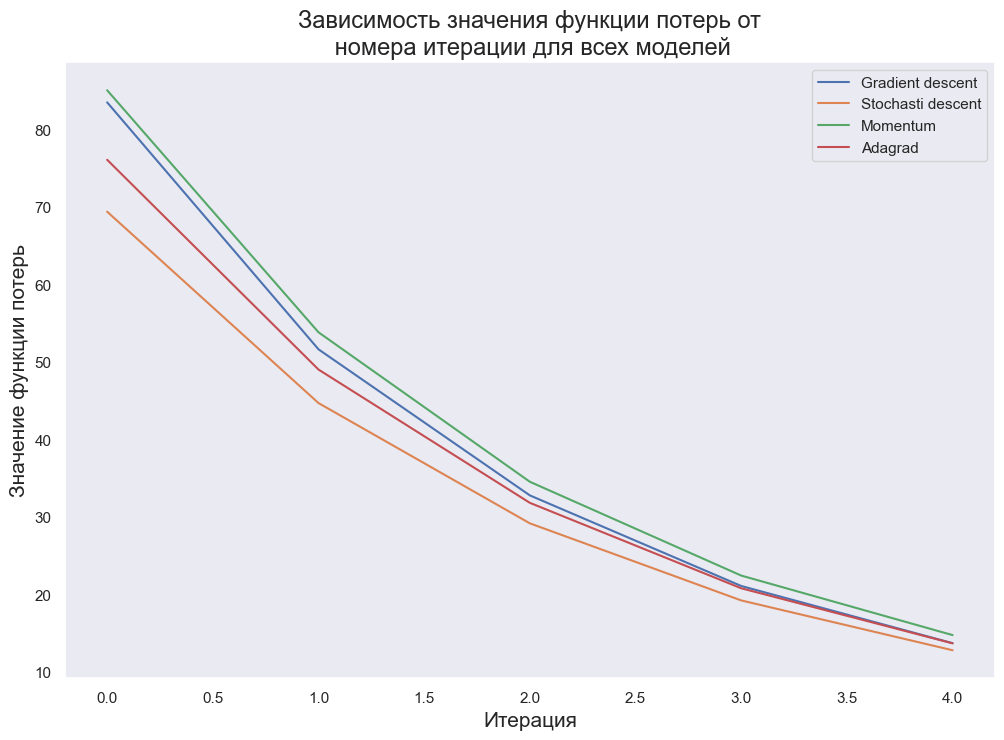

In [20]:
max_iter = 5

gradient = LinReg('GradientDescent', max_iter=max_iter, eta=0.1).fit(X_train_scaled_constant, y_train)
stohastic = LinReg('StochasticDescent', max_iter=max_iter, eta=0.1).fit(X_train_scaled_constant, y_train)
momentum = LinReg('Momentum', max_iter=max_iter, eta=0.1).fit(X_train_scaled_constant, y_train)
adagrad = LinReg('Adagrad', max_iter=max_iter, eta=0.1).fit(X_train_scaled_constant, y_train)

# y_gr = gradient.predict(X_test_scaled_constant) 
# y_st = stohastic.predict(X_test_scaled_constant) 
# y_mo = momentum.predict(X_test_scaled_constant) 
# y_ad = adagrad.predict(X_test_scaled_constant) 

plt.figure(figsize = (12, 8))
plt.plot(gradient.loss_history, label='Gradient descent')
plt.plot(stohastic.loss_history, label='Stochasti descent')
plt.plot(momentum.loss_history, label='Momentum')
plt.plot(adagrad.loss_history, label='Adagrad')


plt.title('Зависимость значения функции потерь от\n номера итерации для всех моделей', fontsize=17)

plt.xlabel('Итерация', fontsize=15)
plt.ylabel('Значение функции потерь', fontsize=15)
plt.legend()
plt.grid()

plt.show()

#### Таким образом, лучше всего сходится стохастическая модель, после нее Adagrad, обычный спуск, и хуже всех - momentum.